In [2]:
# setup
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# add project root to path
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from regression.train_regression_models import train_and_evaluate_regression_model
from feature_selection.feature_selection_functions import save_crossval_results

# set task name
task_name = "cookieTheft"

# run regression and get all relevant variables
model, X_scaled, y, X_train, X_test, y_train, y_test = run_multiple_regression(
    features_path=os.path.join(GIT_DIRECTORY, f"results/features/{task_name}.csv"),
    scores_path=os.path.join(GIT_DIRECTORY, "resources/language_scores_all_subjects.csv"),
    target="PhonemicFluencyScore",
    output_dir=os.path.join(GIT_DIRECTORY, "results/regression"),
    task_name=task_name,
    save_outputs=False
)

# manual K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_list, rmse_list, mae_list = [], [], []
fold_predictions = []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    X_train = X_scaled.iloc[train_index]
    X_test = X_scaled.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    model, y_pred, r2, rmse, mae = train_and_evaluate(X_train, y_train, X_test, y_test)

    # Store metrics
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)

    # Save predictions
    fold_predictions.append(pd.DataFrame({
        "y_test": y_test.values,
        "y_pred": y_pred,
        "fold": fold
    }))

    # Print this fold's results
    print(f"Fold {fold + 1}: R² = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}")

Fold 1: R² = -0.280, RMSE = 5.018, MAE = 3.982
Fold 2: R² = -0.100, RMSE = 4.451, MAE = 3.492
Fold 3: R² = -1.488, RMSE = 7.417, MAE = 4.523
Fold 4: R² = -0.293, RMSE = 5.593, MAE = 4.350
Fold 5: R² = -0.386, RMSE = 4.902, MAE = 3.938


In [3]:
# cross validation summary

# compute mean, std, and 95% CI for R²
r2_mean = np.mean(r2_list)
r2_std = np.std(r2_list, ddof=1)
n_folds = len(r2_list)
r2_se = r2_std / np.sqrt(n_folds)

t_score = stats.t.ppf(0.975, df=n_folds - 1)  # 95% confidence
r2_ci_low = r2_mean - t_score * r2_se
r2_ci_high = r2_mean + t_score * r2_se

print(f"Average R²:   {r2_mean:.3f} ± {r2_se:.3f} (95% CI: [{r2_ci_low:.3f}, {r2_ci_high:.3f}])")
print(f"Average RMSE: {np.mean(rmse_list):.3f}")
print(f"Average MAE:  {np.mean(mae_list):.3f}")



Average R²:   -0.510 ± 0.249 (95% CI: [-1.201, 0.182])
Average RMSE: 5.476
Average MAE:  4.057


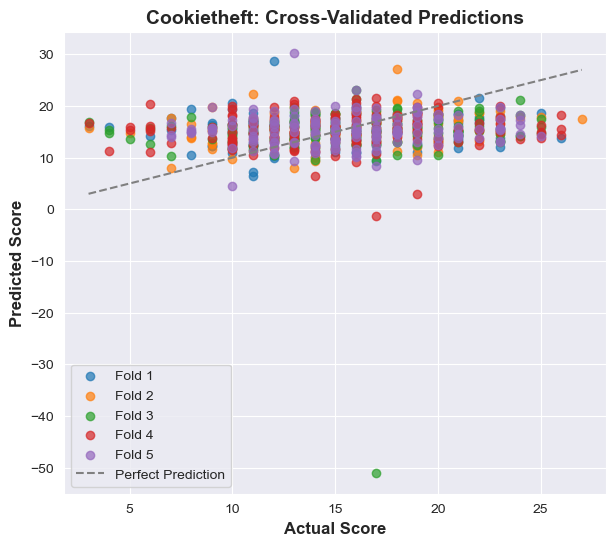

In [4]:
# plot

all_preds = pd.concat(fold_predictions, ignore_index=True)

plt.figure(figsize=(7, 6))
for fold in all_preds['fold'].unique():
    fold_df = all_preds[all_preds['fold'] == fold]
    plt.scatter(fold_df["y_test"], fold_df["y_pred"], label=f"Fold {fold + 1}", alpha=0.7)

plt.plot(
    [all_preds["y_test"].min(), all_preds["y_test"].max()],
    [all_preds["y_test"].min(), all_preds["y_test"].max()],
    linestyle='--',
    color='gray',
    label="Perfect Prediction"
)

plt.xlabel("Actual Score", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Score", fontsize=12, fontweight="bold")
plt.title(f"{task_name.title()}: Cross-Validated Predictions", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
target = "PhonemicFluencyScore"

save_crossval_results(
    r2_list, rmse_list, mae_list,
    r2_mean, r2_std, r2_se, r2_ci_low, r2_ci_high,
    task_name, target,
    output_dir=os.path.join(GIT_DIRECTORY, "results", "cross_validation"),
    all_preds=all_preds
)

saved per-fold CV results to:
/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/cross_validation/cv_folds_cookieTheft_PhonemicFluencyScore.csv
saved CV summary to:
/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/cross_validation/cv_summary_cookieTheft_PhonemicFluencyScore.csv
CV prediction plot saved to: /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/cross_validation/cv_prediction_plot_cookieTheft_PhonemicFluencyScore.png
